In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import lfilter, butter, find_peaks
import scipy

In [2]:
Fn = 710        # несущая частота
Fm = 24         # частота модулируемого сигнала
A = 1           # амплитуда Fn
quant = 512     # число уроовней квантования
Fn_phase = 0    # фаза модулирующего сигнала
Fm_phase = 0    # фаза модулирующего сигнала
t_end = 0.3     # время окончания модуляции сигнала
k_discr = 8     # отношение частоты дискретизации к частоте несущей
f_discr = Fn * k_discr # частота дискретизации
t_discr = 1 / f_discr  # период дискретизации
m = 1           # коэффициент модуляции 0 < m <= 1

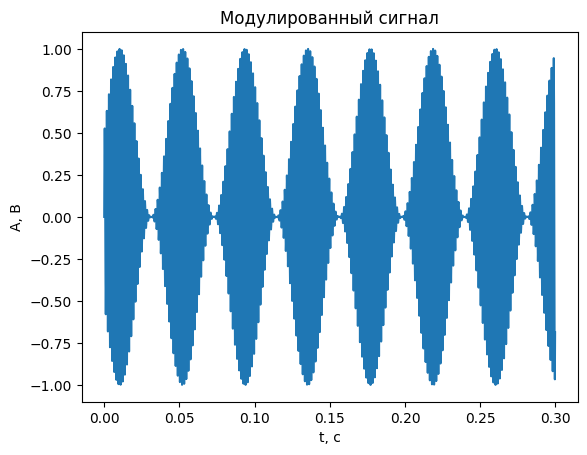

In [3]:
def gen_mod_signal(t):
    return (1 + m * np.sin(2 * np.pi * Fm * t + Fm_phase)) \
        * A * np.sin(2 * np.pi * Fn * t + Fn_phase) * 1 / 2

t = np.arange(0, t_end, t_discr)
mod_signal = np.zeros(len(t))
for i in range(len(t)):
    mod_signal[i] = gen_mod_signal(t[i])

plt.xlabel('t, c')
plt.ylabel('A, В')
plt.title("Модулированный сигнал")
plt.plot(t, mod_signal)

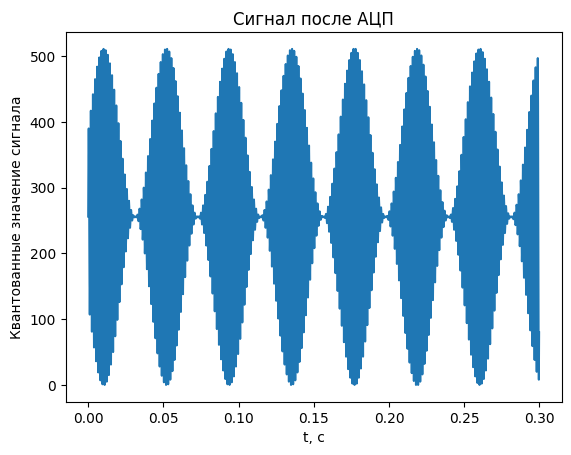

In [4]:
quant_sig = np.zeros(len(mod_signal))
for i in range(len(t)):
    quant_sig[i] = np.floor((mod_signal[i] + m) * quant / (2 * m))

plt.xlabel('t, c')
plt.ylabel('Квантованные значение сигнала')
plt.title("Сигнал после АЦП")
plt.plot(t, quant_sig)

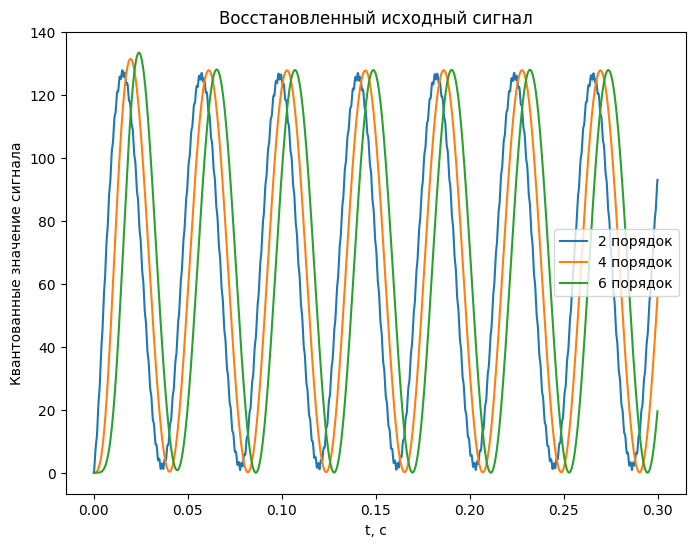

In [7]:
sin_buf1 = [quant_sig[i] * np.sin(i*2*np.pi*Fn/f_discr) for i in range(0, len(quant_sig))]
cos_buf1 = [quant_sig[i] * np.cos(i*2*np.pi*Fn/f_discr) for i in range(0, len(quant_sig))]

b, a = butter(2, Fm * k_discr/(2 * f_discr))
b4, a4 = butter(4, Fm * k_discr/(2 * f_discr))
b6, a6 = butter(6, Fm * k_discr/(2 * f_discr))

first_detection_2 = np.sqrt(lfilter(b, a, sin_buf1) ** 2 + lfilter(b, a, cos_buf1) ** 2)
first_detection_4 = np.sqrt(lfilter(b4, a4, sin_buf1) ** 2 + lfilter(b4, a4, cos_buf1) ** 2)
first_detection_6 = np.sqrt(lfilter(b6, a6, sin_buf1) ** 2 + lfilter(b6, a6, cos_buf1) ** 2)

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["legend.loc"] = "best"
plt.xlabel('t, c')
plt.ylabel('Квантованные значение сигнала')
plt.title("Восстановленный исходный сигнал")

plt.plot(t, first_detection_2, label="2 порядок")
plt.plot(t, first_detection_4, label="4 порядок")
plt.plot(t, first_detection_6, label="6 порядок")
plt.legend()

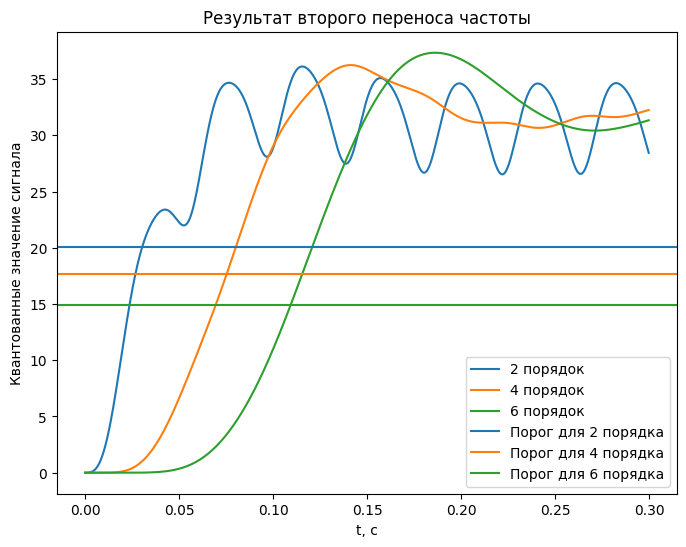

In [8]:
sin_buf2_2 = [first_detection_2[i] * np.sin(i*2*np.pi*Fm/f_discr) \
              for i in range(0, len(quant_sig))]
cos_buf2_2 = [first_detection_2[i] * np.cos(i*2*np.pi*Fm/f_discr) \
              for i in range(0, len(quant_sig))]

sin_buf2_4 = [first_detection_4[i] * np.sin(i*2*np.pi*Fm/f_discr) \
              for i in range(0, len(quant_sig))]
cos_buf2_4 = [first_detection_4[i] * np.cos(i*2*np.pi*Fm/f_discr) \
              for i in range(0, len(quant_sig))]

sin_buf2_6 = [first_detection_6[i] * np.sin(i*2*np.pi*Fm/f_discr) \
              for i in range(0, len(quant_sig))]
cos_buf2_6 = [first_detection_6[i] * np.cos(i*2*np.pi*Fm/f_discr) \
              for i in range(0, len(quant_sig))]


b2, a2 = butter(2, Fm * k_discr/(2 *8* f_discr))
b4_2, a4_2 = butter(4, Fm*k_discr/(2*8*f_discr))
b6_2, a6_2 = butter(6, Fm*k_discr/(2*8*f_discr))


second_detection_2 = np.sqrt(lfilter(b2, a2, sin_buf2_2) ** 2 \
                             + lfilter(b2, a2, cos_buf2_2) ** 2)
second_detection_4 = np.sqrt(lfilter(b4_2, a4_2, sin_buf2_4) ** 2 \
                             + lfilter(b4_2, a4_2, cos_buf2_4) ** 2)
second_detection_6 = np.sqrt(lfilter(b6_2, a6_2, sin_buf2_6) ** 2 \
                             + lfilter(b6_2, a6_2, cos_buf2_6) ** 2)

lbound_2 = np.mean(second_detection_2) * 0.708
lbound_4 = np.mean(second_detection_4) * 0.708
lbound_6 = np.mean(second_detection_6) * 0.708

plt.xlabel("t, c")
plt.ylabel("Квантованные значение сигнала")
plt.title("Результат второго переноса частоты")
plt.plot(t, second_detection_2, label="2 порядок")
plt.plot(t, second_detection_4, label="4 порядок")
plt.plot(t, second_detection_6, label="6 порядок")

plt.axhline(y=lbound_2, label="Порог для 2 порядка", color='C0')
plt.axhline(y=lbound_4, label="Порог для 4 порядка", color='C1')
plt.axhline(y=lbound_6, label="Порог для 6 порядка", color='C2')

plt.legend()

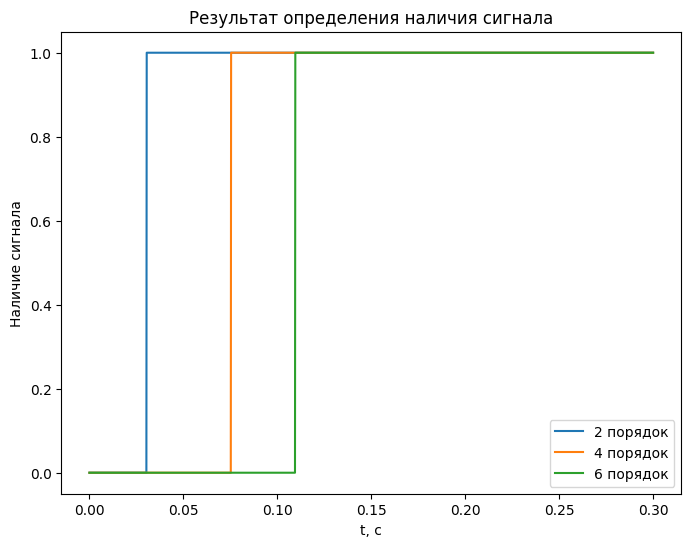

In [9]:
activation = [0 if second_detection_2[i] < lbound_2 else 1 \
              for i in range(len(second_detection_2))]
activation_4 = [0 if second_detection_4[i] < lbound_4 else 1 \
              for i in range(len(second_detection_4))]
activation_6 = [0 if second_detection_6[i] < lbound_6 else 1 \
              for i in range(len(second_detection_6))]


plt.xlabel('t, c')
plt.ylabel('Наличие сигнала')
plt.title("Результат определения наличия сигнала")
plt.plot(t, activation, label="2 порядок")
plt.plot(t, activation_4, label="4 порядок")
plt.plot(t, activation_6, label="6 порядок")
plt.legend()

In [10]:
display(t[np.argmax(activation)])
display(t[np.argmax(activation_4)])
display(t[np.argmax(activation_6)])

0.03045774647887324

0.07535211267605635

0.10950704225352113

In [11]:
Fn2 = Fn + 3 * Fm
mod_signal_2 = mod_signal + 0.5 * np.sin(2 * np.pi * Fn2 * t)
Fn2

782

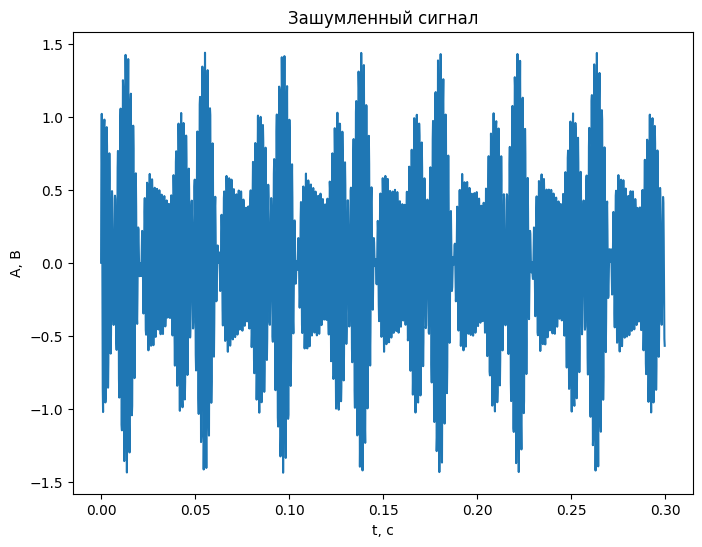

In [12]:
plt.xlabel('t, c')
plt.ylabel('A, В')
plt.title("Зашумленный сигнал")
plt.plot(t, mod_signal_2)

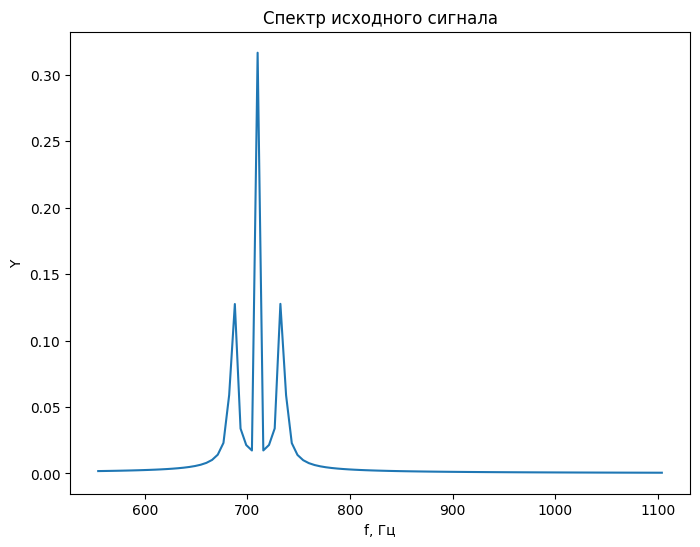

In [13]:
spectrum_1 = abs(np.fft.fft(mod_signal, 1024))
spectrum_1 = spectrum_1 * 2 / len(t)
spectrum_1[0] = spectrum_1[0] / 2
freq = np.fft.fftfreq(1024, d=1 / f_discr)
plt.xlabel("f, Гц")
plt.ylabel("Y")
plt.title("Спектр исходного сигнала")
plt.plot(freq[100:200], spectrum_1[100:200])

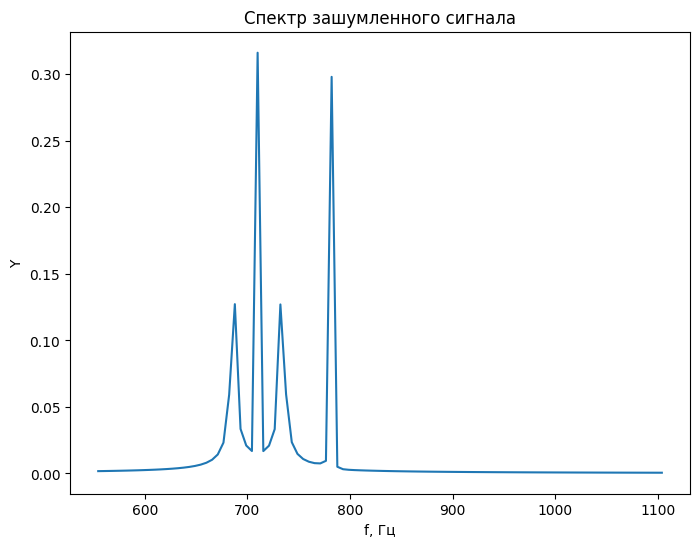

In [14]:
spectrum_2 = abs(np.fft.fft(mod_signal_2, 1024))
spectrum_2 = spectrum_2 * 2 / len(t)
spectrum_2[0] = spectrum_2[0] / 2
freq = np.fft.fftfreq(1024, d=1 / f_discr)
plt.xlabel("f, Гц")
plt.ylabel("Y")
plt.title("Спектр зашумленного сигнала")
plt.plot(freq[100:200], spectrum_2[100:200])

In [15]:
fr_1 = freq[find_peaks(spectrum_1, 0.1)[0]]
fr_2 = freq[find_peaks(spectrum_2, 0.1)[0]]
fr_1 = fr_1[fr_1 > 0]
fr_2 = fr_2[fr_2 > 0]
display(fr_1, fr_2)

array([687.8125, 710.    , 732.1875])

array([687.8125  , 710.      , 732.1875  , 782.109375])